## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('residual_arima.xlsx')
columns_name = ['Residual']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d-%m-%Y')
data_df.set_index('Date', inplace=True)

KeyError: 'Date'

In [ ]:
print(data_df.columns)

Index(['Residual'], dtype='object')


In [ ]:
Data.tail()

,Residual
414,10.641600
415,2.919962
416,1.591668
417,-4.514397
418,11.839940


In [ ]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['Residual'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['Residual'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['Residual'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['Residual'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['Residual'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['Residual'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['Residual'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['Residual'] - data_df['Residual'].shift(lag)) / data_df['Residual'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['Residual'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['Residual'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['Residual'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['Residual'] - data_df['Residual'].mean()) / data_df['Residual'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['Residual'].median()
    mad = np.median(np.abs(data_df['Residual'] - median))
    data_df['mad_z_score'] = (data_df['Residual'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['Residual'] / data_df['Residual'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [ ]:
data_df_drop.head()

,Residual,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,moving_median_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,105.498139,91.733657,-41.266698,-40.998385,91.733657,105.498139,98.615898,86.124330,9.732959,98.615898,...,0.037349,-19.972896,-33.316905,-0.053544,-17.662658,-44.580982,0.00045,2.077496,3.937337,0.139804
1990-06-01,8.131870,15.687365,-91.080401,75.946069,8.131870,15.687365,11.909618,3.662299,5.342542,11.909618,...,0.037349,-16.197276,-22.989524,-0.053544,-9.262969,-33.382714,0.00045,0.166059,0.452609,-0.657065
1990-11-01,20.957314,16.088483,-5.049019,18.328299,16.088483,20.957314,18.522899,17.400774,3.442783,18.522899,...,0.037349,-10.354284,-15.400602,-0.053544,-13.260054,-24.766493,0.00045,0.417840,0.911630,0.264384
1990-12-01,13.279114,20.957314,16.088483,-5.049019,13.279114,20.957314,17.118214,14.653001,5.429307,17.118214,...,0.037349,-9.926321,-12.893160,-0.053544,-12.032233,-22.294936,0.00045,0.267106,0.636828,-0.456295
1991-01-01,32.952153,13.279114,20.957314,16.088483,13.279114,32.952153,23.115634,26.852436,13.910939,23.115634,...,0.037349,-10.752852,-11.088175,-0.053544,-10.896023,-20.372014,0.00045,0.653316,1.340924,0.908864


In [ ]:
data_df_drop.tail()

,Residual,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,moving_median_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,32.700027,54.560245,32.122779,8.553611,32.700027,54.560245,43.630136,37.018496,15.457508,43.630136,...,0.037349,21.693831,27.339254,-0.053544,17.556522,24.608335,0.00045,0.648366,1.331900,-0.511930
2021-05-01,-45.070269,-69.454464,32.700027,54.560245,-69.454464,-45.070269,-57.262366,-41.368005,17.242230,-57.262366,...,0.037349,20.949377,21.008037,-0.053544,17.985843,19.937606,0.00045,-0.878374,-1.451490,-0.432449
2021-06-01,-23.336057,-45.070269,-69.454464,32.700027,-45.070269,-23.336057,-34.203163,-29.346707,15.368408,-34.203163,...,0.037349,20.545446,16.450912,-0.053544,17.896203,16.423667,0.00045,-0.451701,-0.673625,-0.658223
2021-08-01,2.919962,10.641600,-23.336057,-45.070269,2.919962,10.641600,6.780781,1.050696,5.460023,6.780781,...,0.037349,18.558343,13.495577,-0.053544,20.195000,14.078120,0.00045,0.063742,0.266075,-1.293200
2021-09-01,1.591668,2.919962,10.641600,-23.336057,1.591668,2.919962,2.255815,1.411344,0.939246,2.255815,...,0.037349,20.101438,12.766225,-0.053544,15.072429,13.474976,0.00045,0.037665,0.218535,-0.606788


In [ ]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [ ]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['moving_average_12', 'moving_median_12', 'lag_1', 'ema_12',
       'interaction_ma_ema_12', 'rolling_min_2', 'rolling_min_12',
       'rolling_min_3', 'rolling_min_24', 'ema_24', 'rolling_max_2',
       'moving_median_3', 'moving_average_3', 'ema_3', 'moving_average_2',
       'lagged_ma_12', 'Residual', 'interaction_ma_ema_36', 'moving_median_2',
       'ema_2'],
      dtype='object')


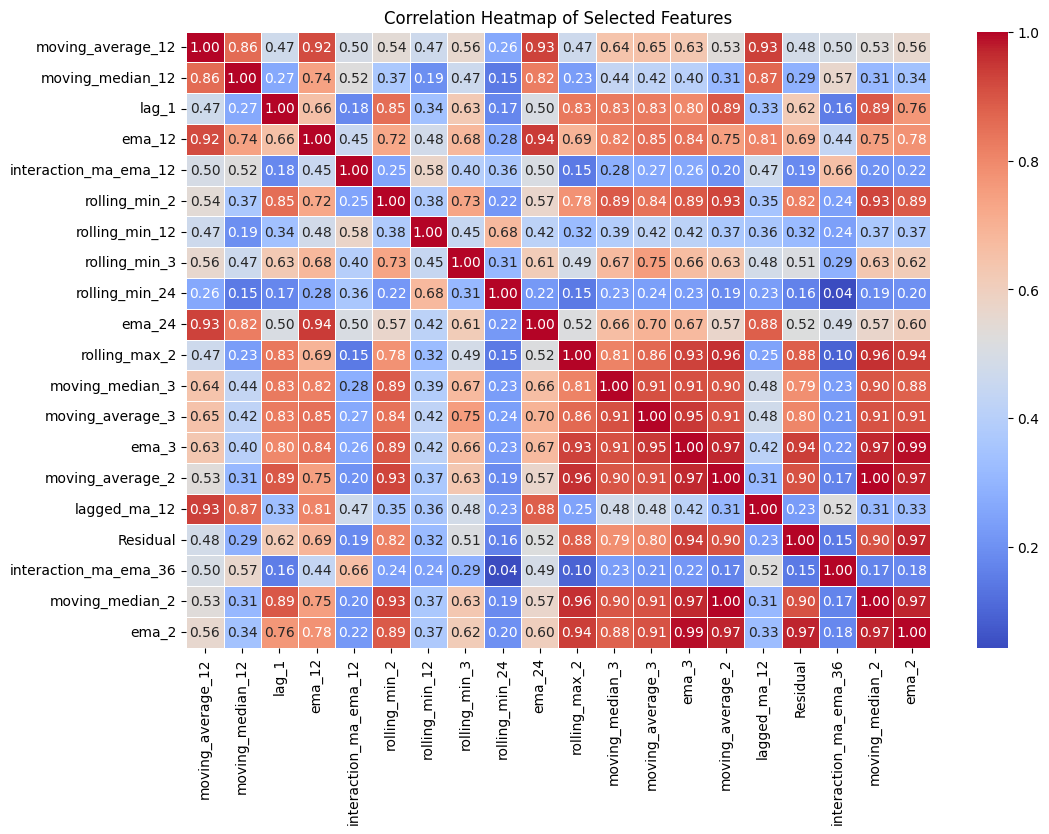

In [ ]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [ ]:
def prepare_time_series_data(data, time_steps=28, test_size=0.3, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=False)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(128, 28, 20) (128,)

Testing set shapes:
(55, 28, 20) (55,)


In [ ]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5116 - mae: 0.6037 - r_squared: -64.9550
Epoch 1: val_loss improved from inf to 0.44972, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 866ms/step - loss: 0.5210 - mae: 0.6048 - r_squared: -52.3038 - val_loss: 0.4497 - val_mae: 0.5764 - val_r_squared: -40.7413
Epoch 2/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.4726 - mae: 0.5835 - r_squared: -65.3009
Epoch 2: val_loss improved from 0.44972 to 0.38324, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.4420 - mae: 0.5585 - r_squared: -52.9655 - val_loss: 0.3832 - val_mae: 0.5252 - val_r_squared: -41.3570
Epoch 3/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3434 - mae: 0.4924 - r_squared: -68.4597
Epoch 3: val_loss improved from 0.38324 to 0.33146, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.3463 - mae: 0.4917 - r_squared: -54.5796 - val_loss: 0.3315 - val_mae: 0.4800 - val_r_squared: -42.7062
Epoch 4/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2687 - mae: 0.4191 - r_squared: -73.1850
Epoch 4: val_loss improved from 0.33146 to 0.28399, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.2874 - mae: 0.4395 - r_squared: -58.2743 - val_loss: 0.2840 - val_mae: 0.4401 - val_r_squared: -44.8169
Epoch 5/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2348 - mae: 0.3981 - r_squared: -81.0899
Epoch 5: val_loss improved from 0.28399 to 0.24669, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.2437 - mae: 0.4053 - r_squared: -63.7842 - val_loss: 0.2467 - val_mae: 0.4094 - val_r_squared: -47.7628
Epoch 6/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2170 - mae: 0.3699 - r_squared: -86.6828
Epoch 6: val_loss improved from 0.24669 to 0.22191, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.2177 - mae: 0.3762 - r_squared: -70.1117 - val_loss: 0.2219 - val_mae: 0.3861 - val_r_squared: -51.5644
Epoch 7/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2087 - mae: 0.3607 - r_squared: -100.8944
Epoch 7: val_loss improved from 0.22191 to 0.21381, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.2004 - mae: 0.3559 - r_squared: -79.8755 - val_loss: 0.2138 - val_mae: 0.3760 - val_r_squared: -55.5508
Epoch 8/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1981 - mae: 0.3656 - r_squared: -105.2223
Epoch 8: val_loss did not improve from 0.21381
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1957 - mae: 0.3538 - r_squared: -85.9682 - val_loss: 0.2188 - val_mae: 0.3795 - val_r_squared: -58.8378
Epoch 9/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1793 - mae: 0.3419 - r_squared: -119.3788
Epoch 9: val_loss did not improve from 0.21381
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1866 - mae: 0.3433 - r_squared: -93.5140 - val_loss: 0.2364 - val_mae: 0.3942 - val_r_squared: -60.0727
Epoch 10/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2005 - mae: 0.3574 - r_squared: -108.1128
Epoch 10: val_loss did not improve from 0.21381
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1921 - mae: 0.3496 - r_squared: -90.7394 - 

In [ ]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.7243 - mae: 0.6891 - r_squared: -63.8711
Epoch 1: val_loss improved from inf to 0.53374, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - loss: 0.7275 - mae: 0.6945 - r_squared: -60.1895 - val_loss: 0.5337 - val_mae: 0.6003 - val_r_squared: -44.3435
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.5872 - mae: 0.6206 - r_squared: -63.3553 
Epoch 2: val_loss improved from 0.53374 to 0.46132, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step - loss: 0.5873 - mae: 0.6185 - r_squared: -59.7942 - val_loss: 0.4613 - val_mae: 0.5473 - val_r_squared: -44.8210
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.4543 - mae: 0.5521 - r_squared: -64.0200 
Epoch 3: val_loss improved from 0.46132 to 0.41279, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step - loss: 0.4500 - mae: 0.5501 - r_squared: -60.0487 - val_loss: 0.4128 - val_mae: 0.5137 - val_r_squared: -46.6043
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.4097 - mae: 0.5192 - r_squared: -65.9395 
Epoch 4: val_loss improved from 0.41279 to 0.37911, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step - loss: 0.4071 - mae: 0.5177 - r_squared: -61.7216 - val_loss: 0.3791 - val_mae: 0.4910 - val_r_squared: -49.1697
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3067 - mae: 0.4599 - r_squared: -67.8352 
Epoch 5: val_loss improved from 0.37911 to 0.35712, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step - loss: 0.3043 - mae: 0.4574 - r_squared: -63.9611 - val_loss: 0.3571 - val_mae: 0.4734 - val_r_squared: -53.4399
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3208 - mae: 0.4608 - r_squared: -73.9675 
Epoch 6: val_loss did not improve from 0.35712
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3122 - mae: 0.4548 - r_squared: -70.1133 - val_loss: 0.3575 - val_mae: 0.4829 - val_r_squared: -59.2775
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2922 - mae: 0.4513 - r_squared: -82.3847 
Epoch 7: val_loss did not improve from 0.35712
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.2920 - mae: 0.4509 - r_squared: -77.3379 - val_loss: 0.3682 - val_mae: 0.4960 - val_r_squared: -64.8506
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2389 - mae: 0.3972 - r_squared: -80.6961 
Epoch 8: val_loss improved from 0.35712 to 0.34361, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step - loss: 0.2418 - mae: 0.4006 - r_squared: -75.8183 - val_loss: 0.3436 - val_mae: 0.4781 - val_r_squared: -64.4597
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1938 - mae: 0.3674 - r_squared: -90.0317  
Epoch 9: val_loss improved from 0.34361 to 0.31011, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step - loss: 0.1929 - mae: 0.3674 - r_squared: -83.8395 - val_loss: 0.3101 - val_mae: 0.4493 - val_r_squared: -61.6525
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2106 - mae: 0.3643 - r_squared: -92.2384  
Epoch 10: val_loss improved from 0.31011 to 0.28952, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step - loss: 0.2080 - mae: 0.3636 - r_squared: -86.9557 - val_loss: 0.2895 - val_mae: 0.4305 - val_r_squared: -60.3012
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1674 - mae: 0.3366 - r_squared: -91.1792  
Epoch 11: val_loss improved from 0.28952 to 0.28164, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step - loss: 0.1692 - mae: 0.3357 - r_squared: -86.0050 - val_loss: 0.2816 - val_mae: 0.4190 - val_r_squared: -62.0353
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1885 - mae: 0.3497 - r_squared: -102.1784 
Epoch 12: val_loss improved from 0.28164 to 0.27805, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step - loss: 0.1874 - mae: 0.3483 - r_squared: -97.7783 - val_loss: 0.2780 - val_mae: 0.4156 - val_r_squared: -63.3442
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1281 - mae: 0.2968 - r_squared: -99.1346  
Epoch 13: val_loss improved from 0.27805 to 0.27439, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - loss: 0.1287 - mae: 0.2982 - r_squared: -92.9198 - val_loss: 0.2744 - val_mae: 0.4097 - val_r_squared: -63.0488
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1665 - mae: 0.3310 - r_squared: -113.6149 
Epoch 14: val_loss improved from 0.27439 to 0.27300, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - loss: 0.1662 - mae: 0.3304 - r_squared: -105.1829 - val_loss: 0.2730 - val_mae: 0.4106 - val_r_squared: -62.0023
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1544 - mae: 0.3213 - r_squared: -98.0853  
Epoch 15: val_loss did not improve from 0.27300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.1556 - mae: 0.3217 - r_squared: -91.5136 - val_loss: 0.2744 - val_mae: 0.4128 - val_r_squared: -62.0884
Epoch 16/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1268 - mae: 0.2775 - r_squared: -95.7730  
Epoch 16: val_loss did not improve from 0.27300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.1263 - mae: 0.2781 - r_squared: -89.6354 - val_loss: 0.2759 - val_mae: 0.4126 - val_r_squared: -62.0077
Epoch 17/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1047 - mae: 0.2667 - r_squared: -100.7288 
Epoch 17: val_loss did not improve from 0.27300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.1051 - mae: 0.2673 - r_squared: -94

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step - loss: 0.0854 - mae: 0.2266 - r_squared: -93.4633 - val_loss: 0.2721 - val_mae: 0.4109 - val_r_squared: -62.5417
Epoch 21/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1193 - mae: 0.2770 - r_squared: -104.7447 
Epoch 21: val_loss improved from 0.27207 to 0.26830, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step - loss: 0.1188 - mae: 0.2767 - r_squared: -97.7125 - val_loss: 0.2683 - val_mae: 0.4081 - val_r_squared: -63.1052
Epoch 22/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1310 - mae: 0.3015 - r_squared: -102.1950 
Epoch 22: val_loss improved from 0.26830 to 0.26615, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step - loss: 0.1307 - mae: 0.3024 - r_squared: -95.4912 - val_loss: 0.2661 - val_mae: 0.4036 - val_r_squared: -61.7154
Epoch 23/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0865 - mae: 0.2401 - r_squared: -103.5176 
Epoch 23: val_loss did not improve from 0.26615
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0858 - mae: 0.2390 - r_squared: -97.4331 - val_loss: 0.2669 - val_mae: 0.4027 - val_r_squared: -59.6092
Epoch 24/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1234 - mae: 0.2829 - r_squared: -101.5641 
Epoch 24: val_loss did not improve from 0.26615
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.1200 - mae: 0.2787 - r_squared: -95.4377 - val_loss: 0.2684 - val_mae: 0.4042 - val_r_squared: -59.4727
Epoch 25/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0826 - mae: 0.2353 - r_squared: -105.7089 
Epoch 25: val_loss did not improve from 0.26615
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.0837 - mae: 0.2365 - r_squared: -99.

In [ ]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


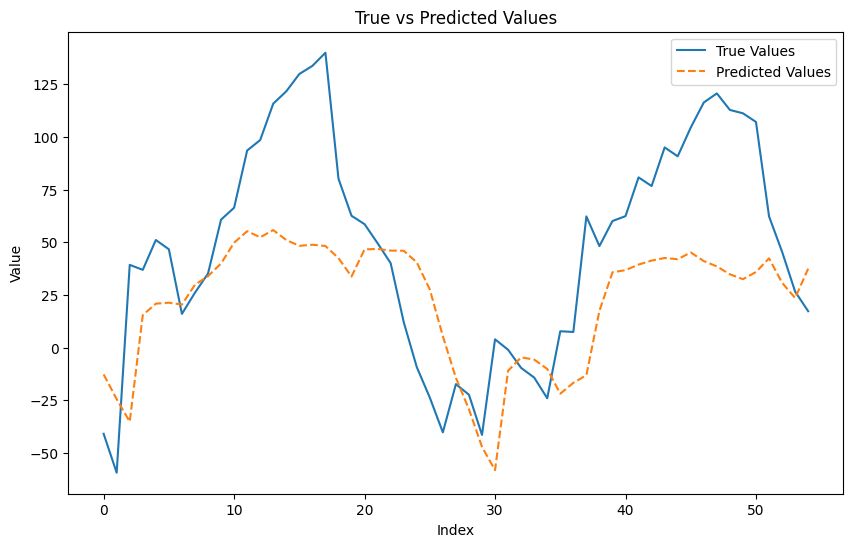

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


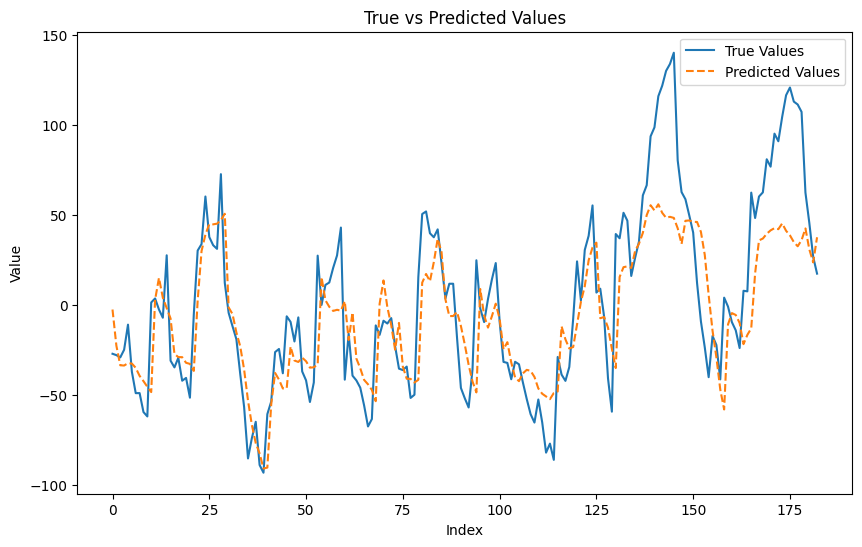

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


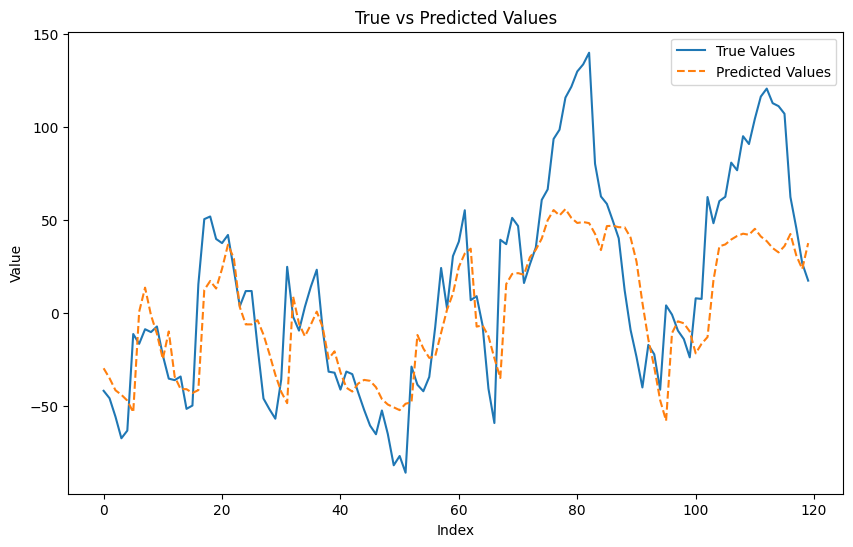

In [ ]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


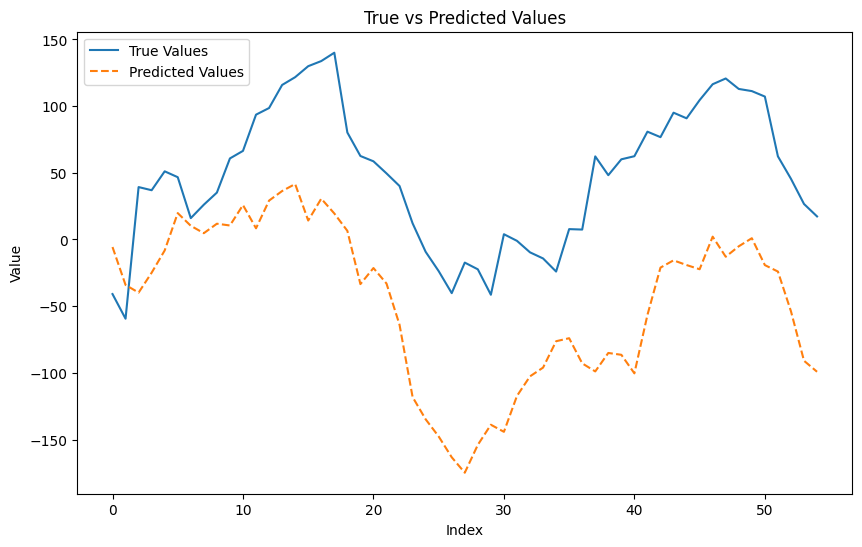

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


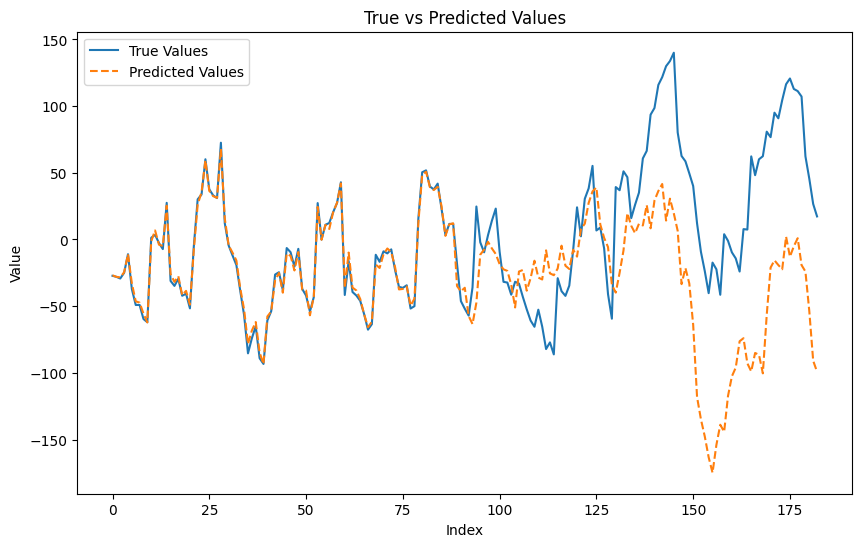

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


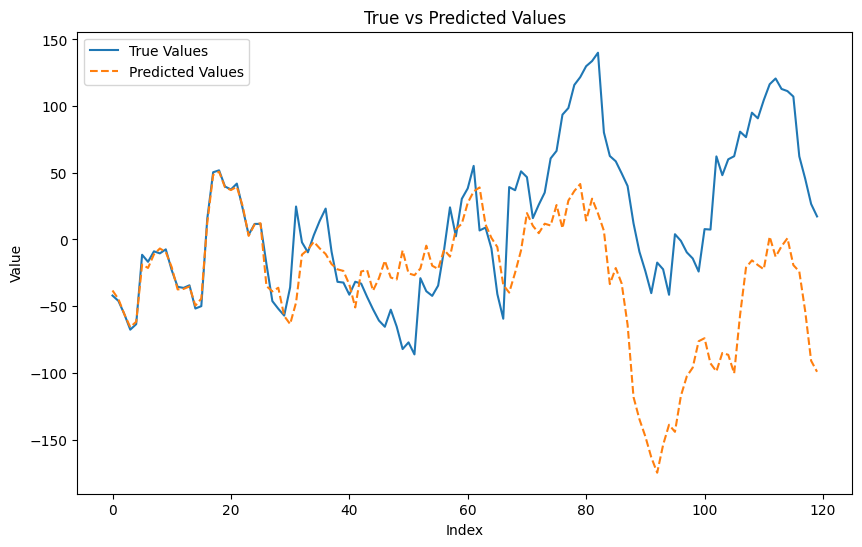

In [ ]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [ ]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


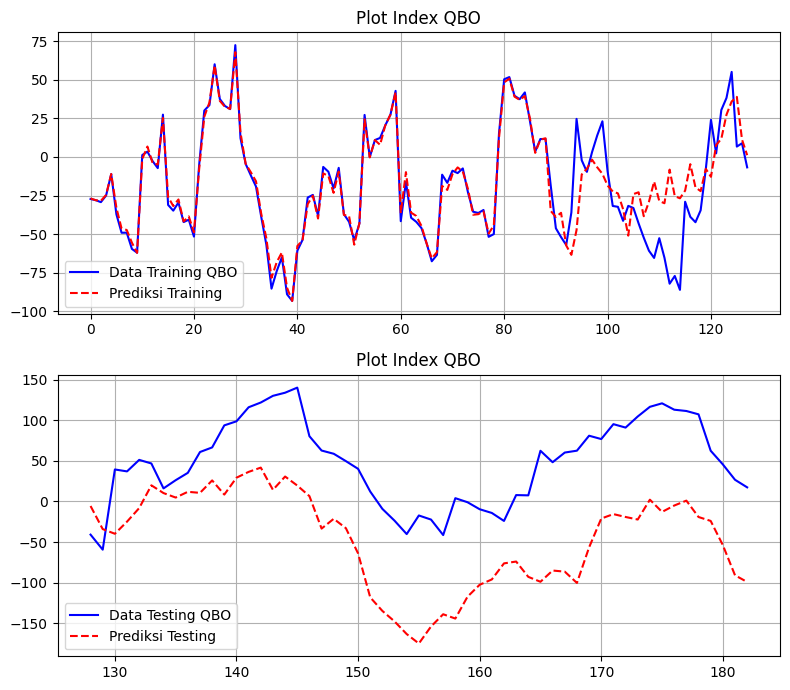

In [ ]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [ ]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [ ]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.3921404183740061
RMSE:  0.6262111611701009
R-squared:  0.6421953438167087
MAE:  0.47282034241597154
Log Likelihood:  -57784.014938392604
MAPE:  278.04319539261866


In [ ]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  1.401282876706461
RMSE:  1.1837579468398347
R-squared:  -0.27858673684916924
MAE:  0.7043900307598876
Log Likelihood:  -67464.21062452388
MAPE:  338.56463700488825


In [ ]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.8407770592789733
RMSE:  0.9169389615884872
R-squared:  0.24591019774445644
MAE:  0.7430336584841274
Log Likelihood:  -5383.611051362974
MAPE:  186.69405924362584


In [ ]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  4.417835320088585
RMSE:  2.1018647244978887
R-squared:  -2.9623399879393837
MAE:  1.9572780876468068
Log Likelihood:  -12160.55330183449
MAPE:  335.4257195658711


In [ ]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [ ]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  947.5872574687244
RMSE:  30.78290527985824
R-squared:  0.6421953458792976
MAE:  23.242613209922265
Log Likelihood:  -86872.39980996473
MAPE:  193.6640139196994


In [ ]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  3386.1285024632134
RMSE:  58.1904502686069
R-squared:  -0.27858677718879155
MAE:  34.62597490172472
Log Likelihood:  -309998.92372696055
MAPE:  191.94332746574236


In [ ]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  1201.861015690272
RMSE:  34.66786719269405
R-squared:  0.6015861483098905
MAE:  26.440214878132178
Log Likelihood:  -72221.93356540089
MAPE:  104.48951629215195


In [ ]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  5159.370047048944
RMSE:  71.82875501530667
R-squared:  -0.7103179701346467
MAE:  51.591085844583496
Log Likelihood:  -309672.47544692125
MAPE:  283.95006316720384


In [ ]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  2031.694737672972
RMSE:  45.07432459475097
R-squared:  0.2459102052200688
MAE:  36.525594060268034
Log Likelihood:  -55922.146905332986
MAPE:  123.75498324592438
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  481.75982456846185
RMSE:  21.94902787297109
R-squared:  0.629408917194842
MAE:  17.535082375789315
Log Likelihood:  -30950.252904631758
MAPE:  223.70305053733713


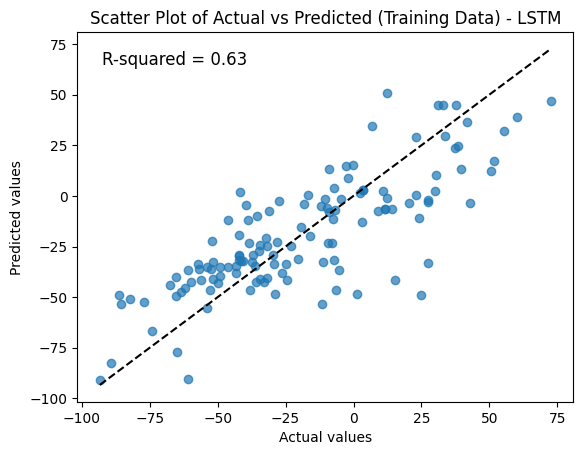

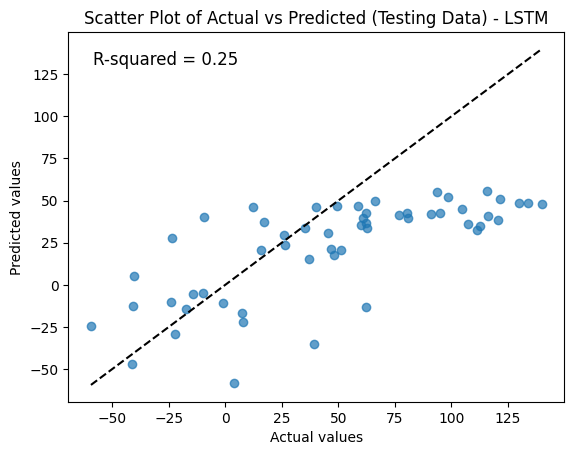

In [ ]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [ ]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  10675.473431598015
RMSE:  103.32218266954108
R-squared:  -2.9623401192803356
MAE:  96.21468074990977
Log Likelihood:  -293626.0609882717
MAPE:  549.7927041175229
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  253.98810322560388
RMSE:  15.937004211130896
R-squared:  0.8046210551527034
MAE:  8.162077857582698
Log Likelihood:  -16372.862738688846
MAPE:  38.17992343568043


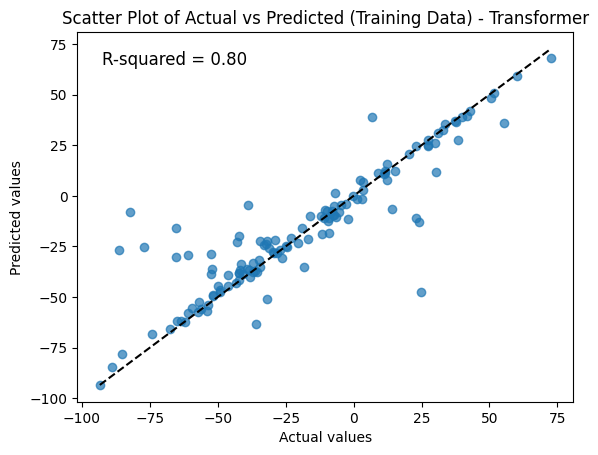

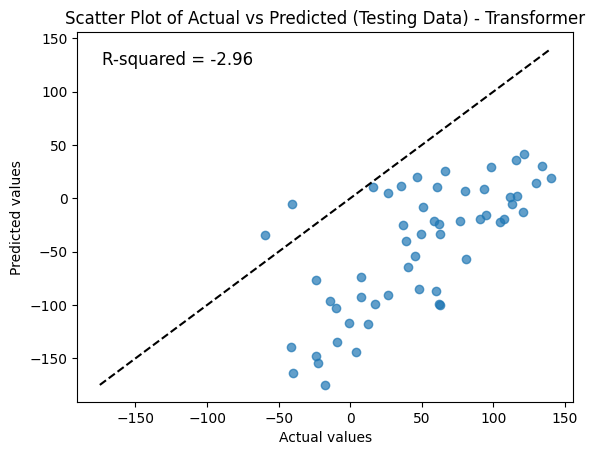

In [ ]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

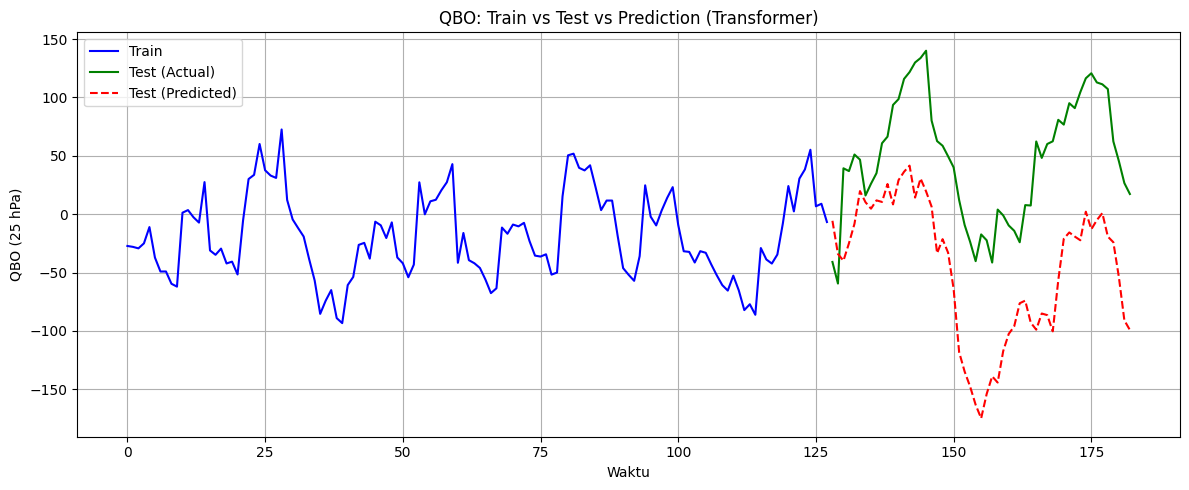

In [ ]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

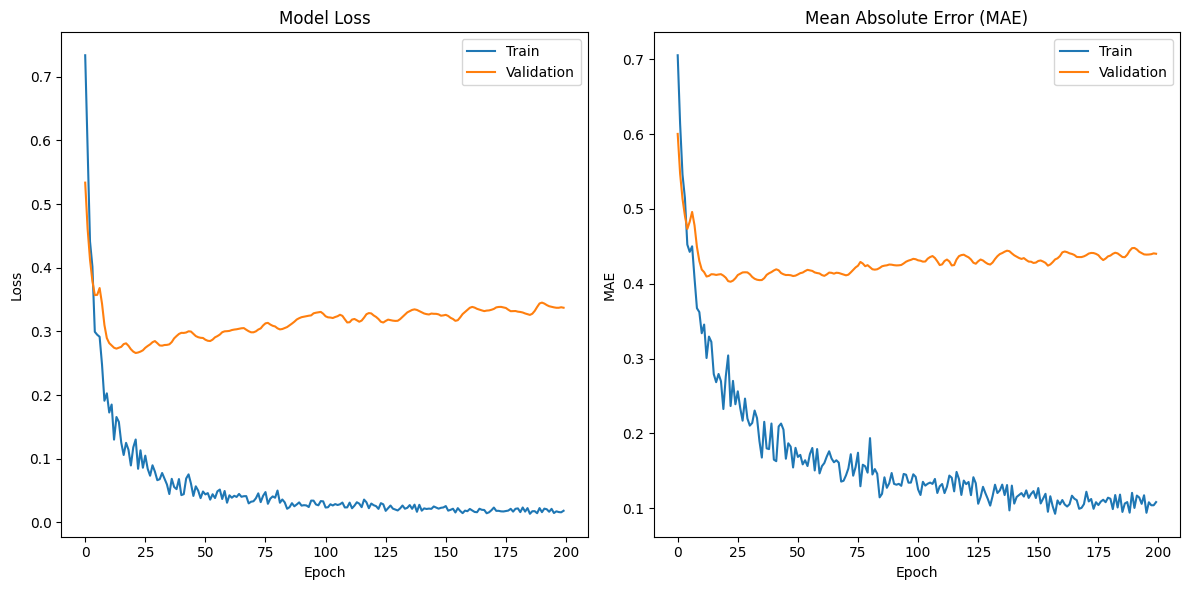

In [ ]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [ ]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

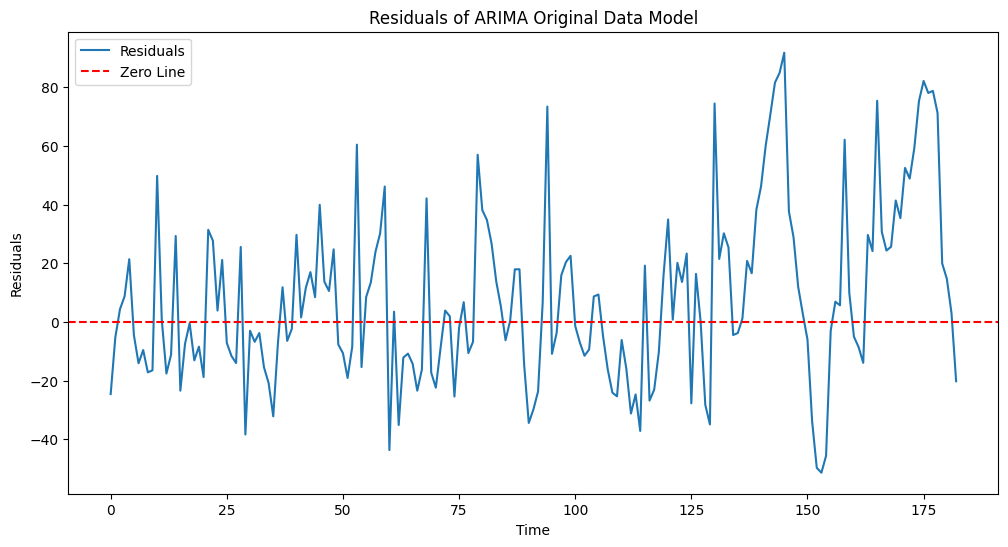

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

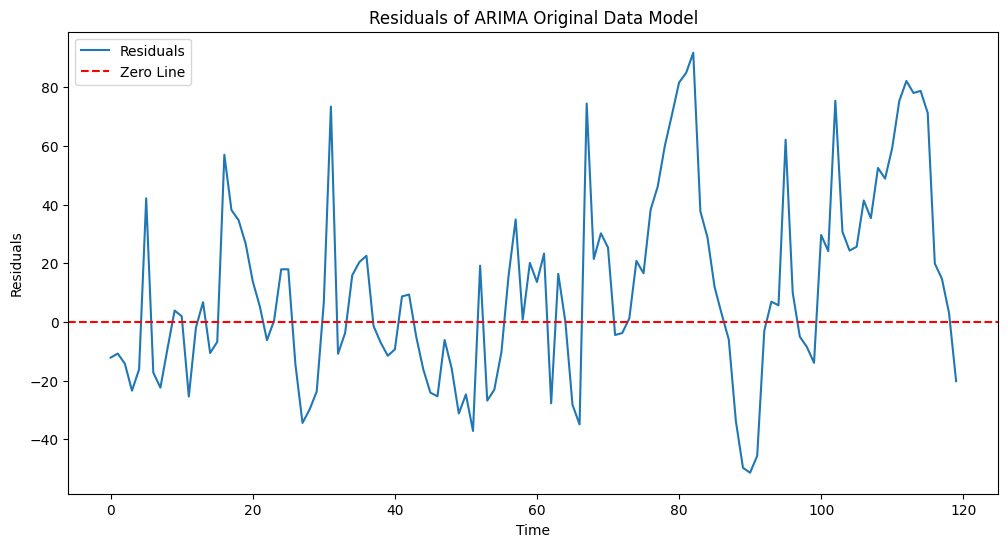

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [ ]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

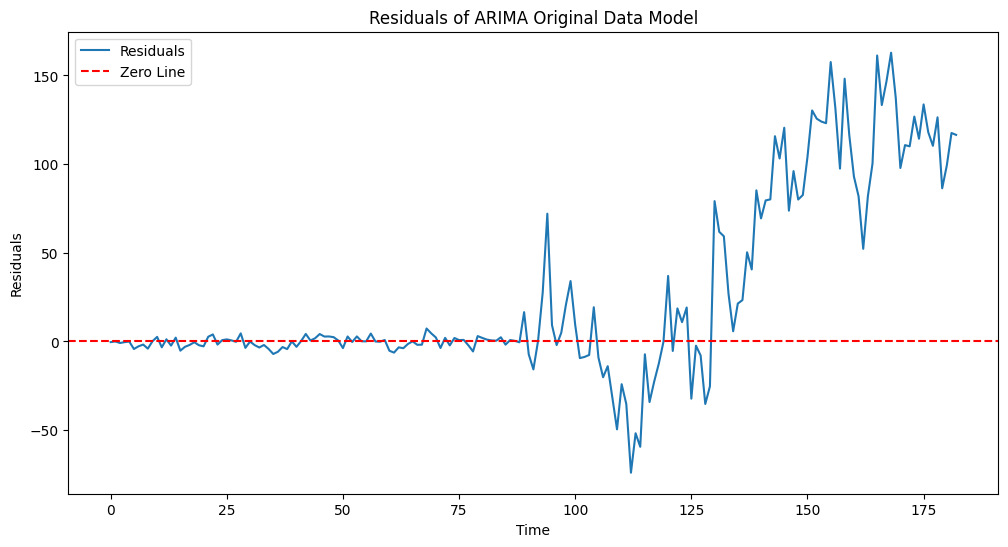

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

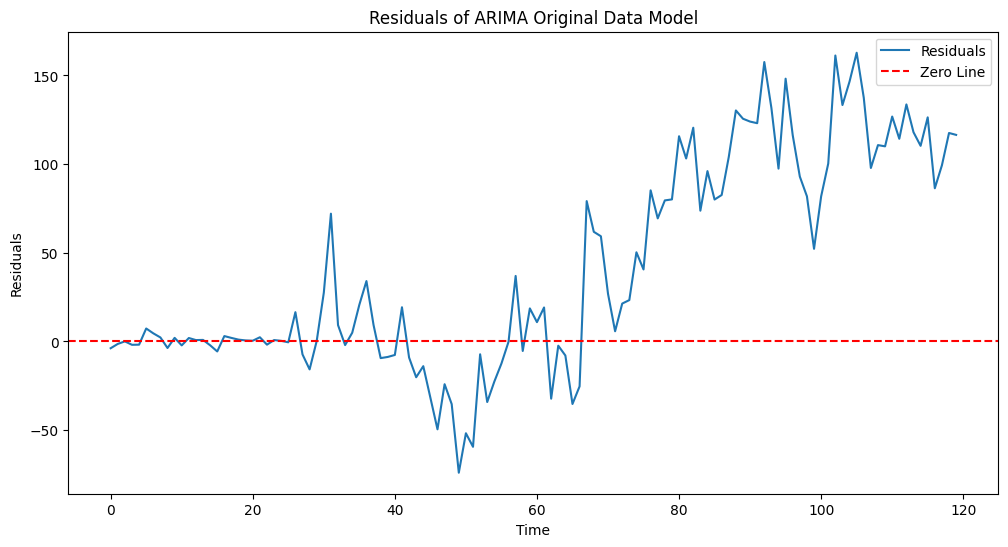

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [ ]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9566370977712573
P-value: 2.0684358771215763e-05
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

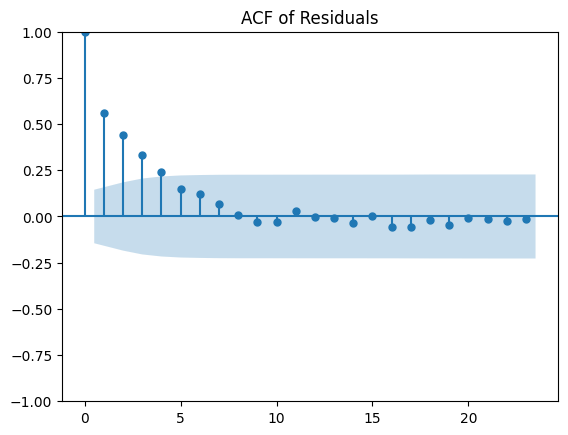

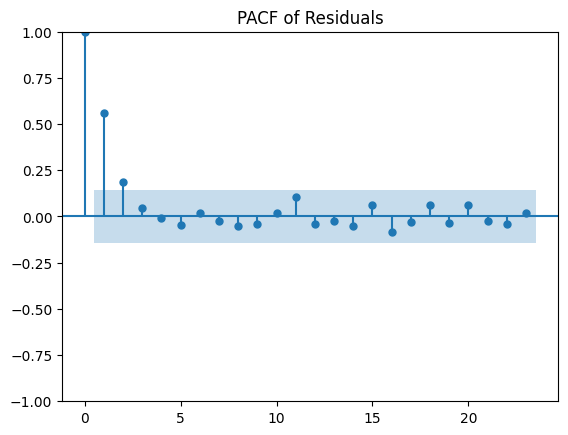

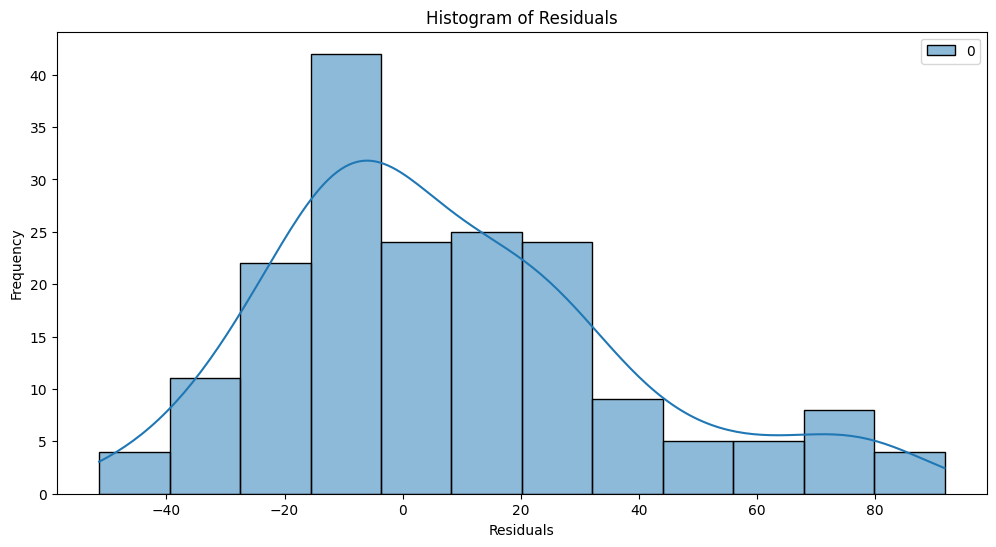

In [ ]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9598531780546526
P-value: 0.0012312251350362208
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

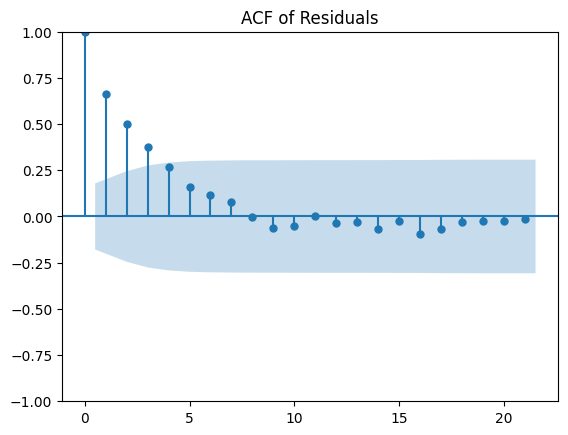

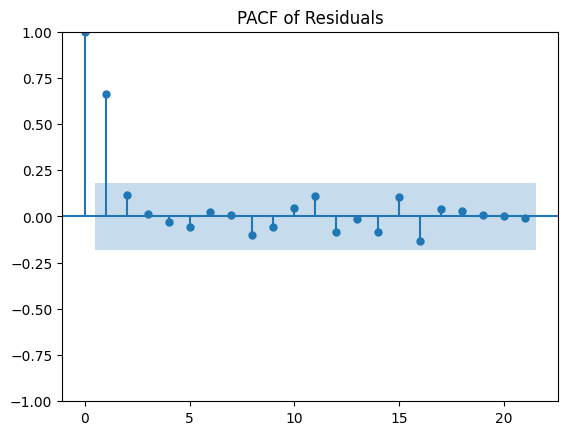

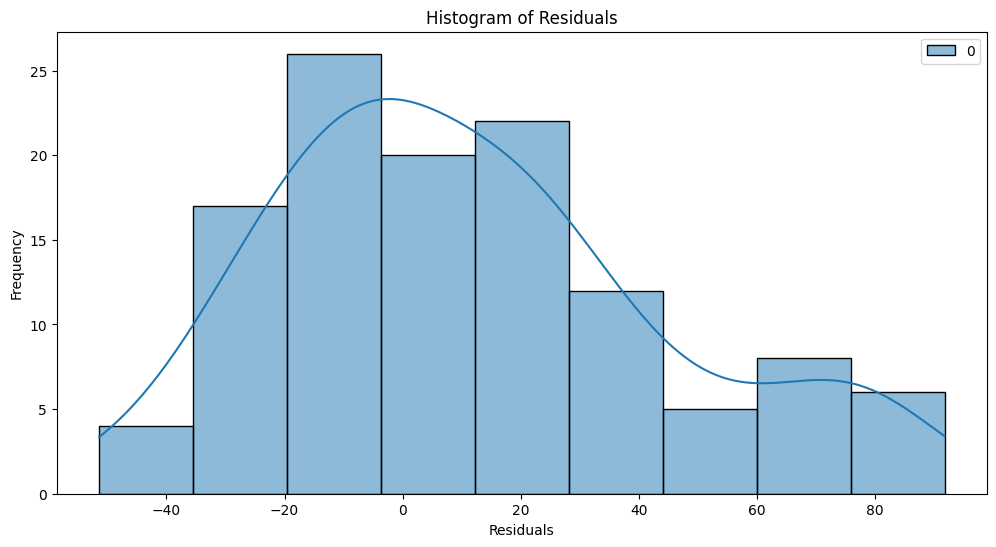

In [ ]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.803829683676477
P-value: 2.063795681889049e-14
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

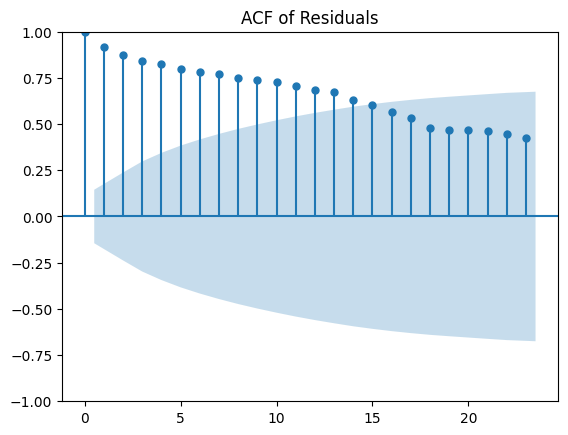

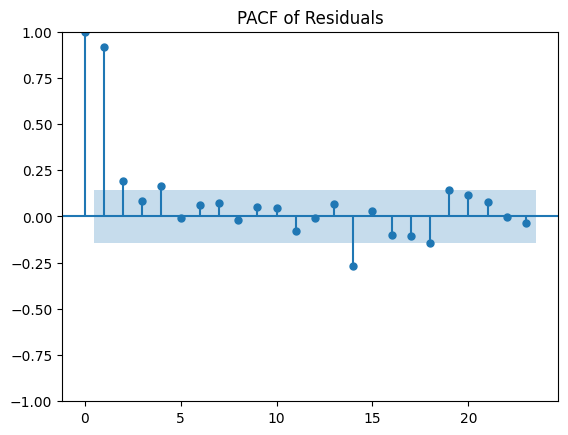

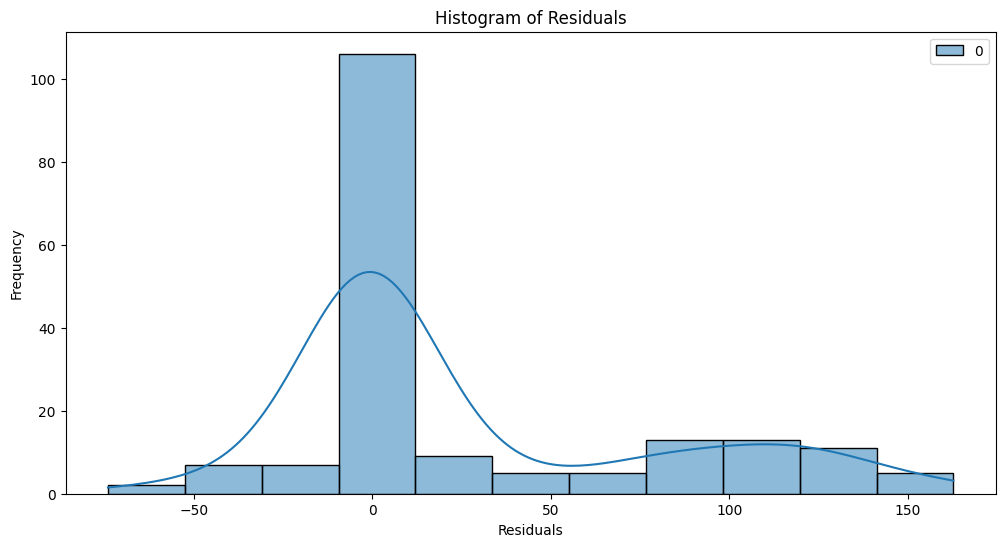

In [ ]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9144628452763944
P-value: 1.1643582501800648e-06
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

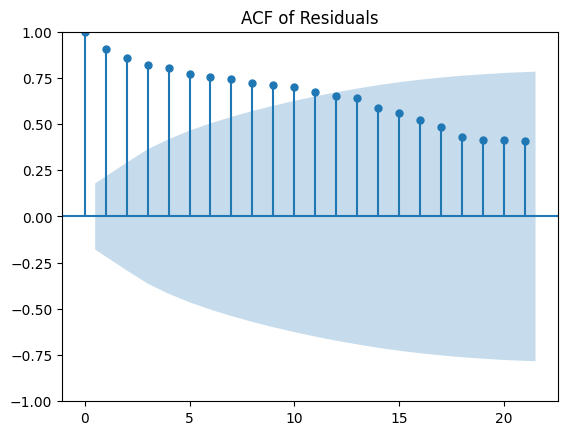

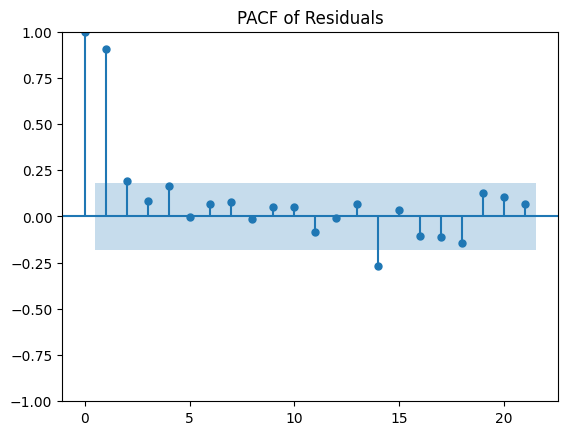

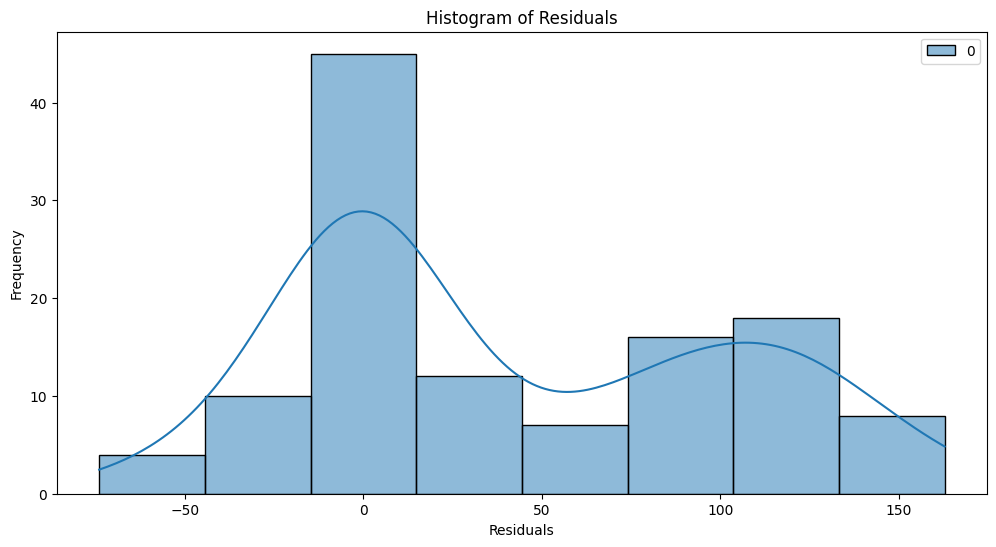

In [ ]:
residual_analysis(residuals_final2)